$
\DeclareMathOperator*{\P}{\operatorname{P}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\xv}{\mathbf{x}}
\newcommand{\E}{\mathbb{E}}
$

<h1><center><br/>Generative Adversarial Networks</center></h1>

<font size="3">
    <center>
        Jason D. Stock
        <br/>
        <br/>
        <i>Introduction to Machine Learning</i>
        <br/>
        <i>April 19<sup>th</sup>, 2019</i>
    </center>
</font>

---

# Table of Contents

* [Overview](#Overview)
* [Random Variables](#Random-Variables)
* [Neural Networks](#Neural-Networks)
    * [Inception Score Evaluation](#Inception-Score-Evaluation)
    * [Inception Score Implementation](#Inception-Score-Implementation)
    * [Generative Adversarial Network Implementation](#Generative-Adversarial-Network-Implementation)
        * [Fully Connected GAN](#Fully-Connected-GAN)
        * [Deep Convolutional GAN](#Deep-Convolutional-GAN)
* [Future Work](#Future-Work)
* [Conclusion](#Conclusion)

# Overview  

There is a recent application of Machine Learning known as Generative Adversarial Networks (GANs), which was formally introduced in a paper by Ian J. Goodfellow *et al.* in 2014 [ 1 ]. These types of networks belong to the set of generative models which can be used to generate / produce new data. Some of the common applications for GANs include; image generation, text-to-image synthesis, image inpainting, etc. For this notebook, I will explore the structure and training process of different types of GANs by generating images of "hand-written" digits that appear similar to those in the MNIST dataset. 

The primary models are implemented using [PyTorch](https://pytorch.org) for simplicity and CUDA support. Using PyTorch, different network structures can easily be modified and experimented with to contrast results and create a model that best represents the data. This includes comparing a *naive* [fully-connected network](#Fully-Connected-GAN) with a more complex [deep convolutional GAN](#Deep-Convolutional-GAN) as detailed in the further sections. Aside from comparing visual accuracy, a modified Inception Score will be used as a metric for performance.

We can begin by importing the necessary libraries from PyTorch and those for math and visualization purposes.

In [1]:
import torch
from torch import nn, optim
from torch.utils import data
from torch.autograd.variable import Variable

import torchvision
import torchvision.transforms as transforms

import math
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from ipywidgets import FloatProgress
from IPython.display import display

rc('animation', html='jshtml');

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Experiment specific `options` are defined early in the notebook to ensure consistency and to avoid simple errors throughout. It may seem ambiguous at this time, but each of these class variables will be explained in detail below. For now, we will declare the variable `opt` to represent the class.

In [2]:
class options():
    def __init__(self):
        # dimensionality of the latent space
        self.latent_dim = 100
        
        # batch size
        self.batch_size = 64

        # number of image channels
        self.n_channels = 1

        # size of each image dimension
        self.img_size = 28
        
        # number of training epochs
        self.n_epochs = 30
        
        # learning rate for backprop
        self.lr = 1e-3
        
        # Adam beta 1 parameter
        self.beta_1 = 0.50
        
        # Adam beta 2 parameter
        self.beta_2 = 0.999
        
        # image shape
        self.img_shape = (self.n_channels, self.img_size, self.img_size)
        
opt = options()

Data can conveniently be downloaded from the PyTorch vision package. Upon downloading, the training and test datasets undergo a transformation by resizing the shape, converting to a `torch.FloatTensor`, and normalizing each sample. Data is normalized for each channel (there is only one for the MNIST data) by forcing the values in the range $[-1, 1]$. This is done by specifying a standard deviation of $\sigma = 0.5$, and computing a new intensity $I^{\prime} = (I - \mu)\;/\;\sigma$ for that channel. This will improve the quality of our generated images and the math behind creating them.

In [3]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.Resize(opt.img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                  ]))
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.Resize(opt.img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                  ]))

data_loader = torch.utils.data.DataLoader(train_data, batch_size=opt.batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=opt.batch_size,
                                          shuffle=True)

Processing...
Done!


After downloading the data, each set is loaded into the respective `DataLoader` to ease iterating over the samples in batches. The first ten images from the first batch is shown with the custom `imshow` function below. This takes as input a tensor of the images, and displays them side-by-side.

Image batch shape: torch.Size([64, 1, 28, 28])


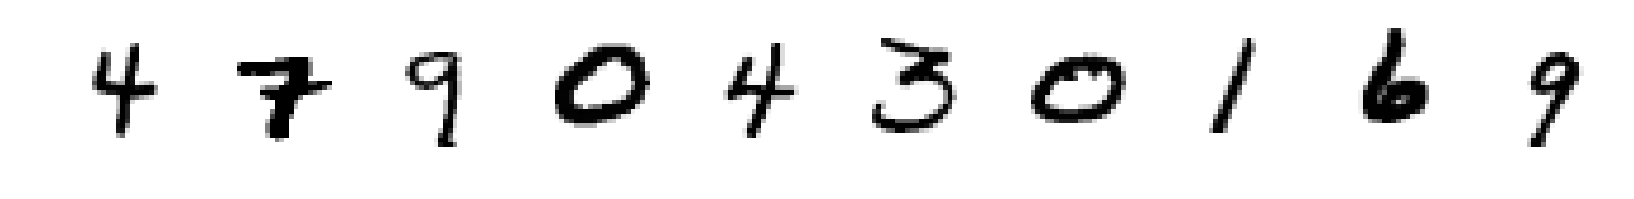

In [4]:
dataiter = iter(data_loader)
imgs, labels = dataiter.next()

def imshow(imgs, n_imgs=None):
    items = n_imgs
    cols = 10
    if n_imgs is None :
        items = imgs.shape[0]
        rows = int(items / 8) + 1 if items > 10 else 1
        fig = (14, 10)
    else:
        rows = int(n_imgs / 10) + 1 if n_imgs > 10 else 1
        fig = (14, rows)

    plt.figure(figsize=fig)
    for i in range(items):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(-imgs[i, :].reshape((28, 28)), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.show();

print('Image batch shape: {}'.format(imgs.shape))
imshow(imgs[:10, ...])

The item returned from iterating over the `DataLoader` has the shape $(B, C, H, W)$, representing a batch $B$ of $H \times W$ pixel images with $C$ channels. Each of these pixels have a different intensity, and together creates the image, but we need different ways to organize or *think* about an image. One way is to flatten the image to a vector with the support of the functions `images_to_vectors` and `vectors_to_images`.

In [5]:
def images_to_vectors(images):
    return images.view(images.size(0), -1)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), opt.n_channels, opt.img_size, opt.img_size)

print('Vector shape: {}'.format(images_to_vectors(imgs[:1, ...]).shape))

Vector shape: torch.Size([1, 784])


Suppose a single image of the number *nine*, which is represented as a square $ n\times n$ square matrix, is flattened to a $1\times n^2$ vector.  If this vector was reshaped to its original dimensions it would obviously represent a *nine* again. However, there exists an infinite number of images that take this same shape, and do **not** take the qualities of a *nine*.  Therefore, it can be inferred that the $1\times n^2$ vectors that do represent a *nine* fit a very specific probability distribution over the entire vector space.

The problem of generating an image of a *nine* can now be interpreted as finding the probability distribution over the $1\times n^2$ vector space. This can be accomplished by taking a random variable and mapping it to this very specific and highly complex probability distribution space. However, it becomes nearly impossible to directly express this distribution. There are, however, probability distributions that we can sample from that are well represented, so perhaps these can be leveraged to accomplish the problem.  

# Random Variables  

A continuous random variable $U$ has the probability density of a uniform distribution, denoted $U \sim \mathcal{U}[a, b]$, if the probability density function (PDF) is,

$$
f_U(u)=
\begin{cases}
  \frac{1}{b-a} & \text{if}\ u \in [a, b] \\
  0 & \text{otherwise}
\end{cases}
$$

The cumulative distribution function (CDF) of a random variable $U$, evaluated at $u$, is the probability that $U$ will take a probability less than or equal to $u$ [ 2 ]. This can be directly solved for by integrating the PDF over the interval $0$ to $u$. Let's represent the CDF of a standard uniform random variable on the support of $U$ as,

$$
F_U(u)=
\operatorname{P}(U\leq u) = \int_0^u \! f_U(t) \, \mathrm{d}t = u \quad \forall u \in [0,1]
$$

The standard uniform PDF and the respective CDF on the interval from $0$ to $1$ are shown below.

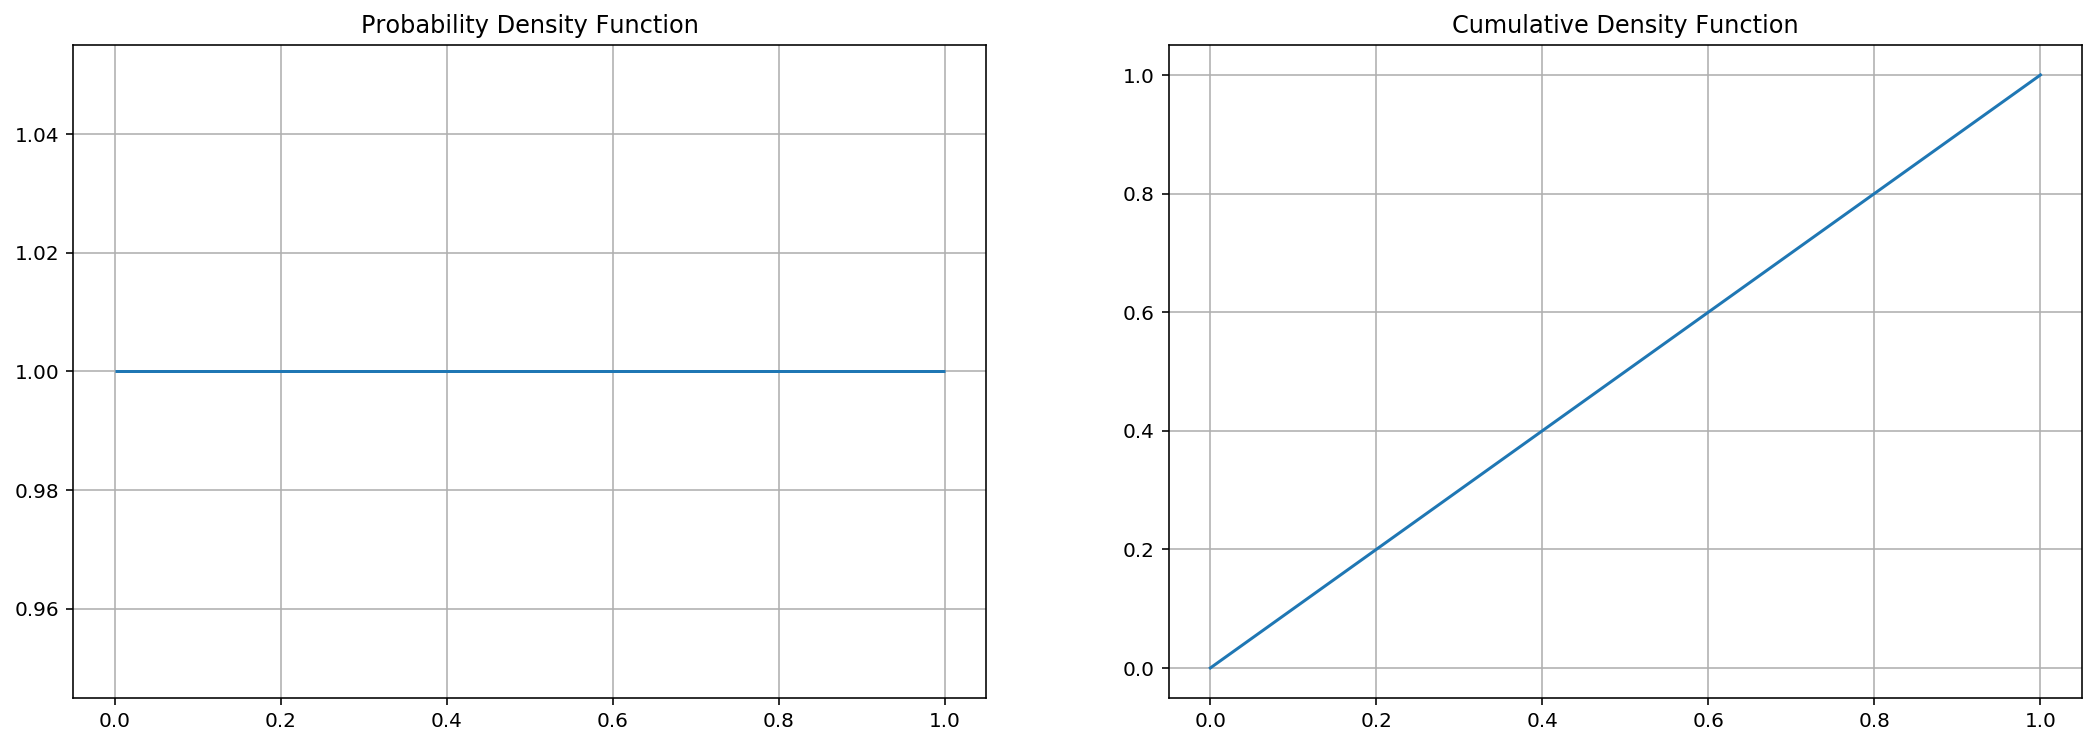

In [6]:
a, b = 0, 1

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1); plt.hlines(1/(b-a), a, b, 'tab:blue')
plt.title('Probability Density Function'); plt.grid(True)

plt.subplot(1, 2, 2); plt.plot([0, 1])
plt.title('Cumulative Density Function'); plt.grid(True);

We know how to sample from $U$ fairly easily, so how can we use this to sample from another distribution? Such as the complex distribution that represented a *nine*.  We can define $X$ as a random variable with the CDF as $F_X(x)=\P(X \leq x)$. If $F_X$ is strictly increasing, then $F_X(x) = u$ is unique for each $0 < u < 1 $, denoted by $x = F_X^{-1}(u)$. Therefore, 

$$
F_X(x)=
\P(U \leq F_X(x)) = \P(F_X^{-1}(U) \leq x)
$$

This indicates that if $u_0, u_1, \dots, u_n$ are sampled from a uniform distribution, and $x_i$ is the solution to $F_X(x) = u_i$, then $x_0, x_1, \dots, x_n$ are sampled from a distribution $F_X$ [ 3 ]. A generalization for this defines the random variable $Y = F_X^{-1}(U)$ as having the same CDF as $X$. In other words, we are able to obtain a value from a target distribution from passing a value from a uniform distribution through the inverse transform function. However, defining the transform function is not simply expressible, and is something that has to be learned. Perhaps we could train a neural network to learn said transform function.

# Neural Networks  

There are two prominent models in machine learning: discriminative models and generative models [ 4 ]. Each are used in a specific use case due to their differences in underlying probability inferences. A discriminative model is trained to find the conditional probability $\P(Y \;|\; X=x)$; that is, given some sample $x$, what is the probability of class $Y$? An example of this is logistic regression, where a logistic function could be used to determine the probability of a sample belonging to some class.  

A generative model estimate the joint probability $\P(X \:,\: Y) = \P(X \;|\; Y)\P(Y)$; that is, given a hidden representation of $Y$, we can find the associated features for $X$. This is done by estimating not only the probability of the label, but also the features. Thus, a generative model is trained to represent the distribution for each class. We would like to use the idea of generative models in our approach to generate features of a complex distribution given samples taken from a uniform distribution.

To accomplish this we will experiment with the previously mentioned subclass of generative models known as Generative Adversarial Networks (GAN). The concept defines two neural networks, a generator model $G$ that attempts to provide samples similar to the expected data, and a discriminator $D$ that tries to resolve fake images from real ones. Both of these networks coexist as to be adversaries towards one another while continuously improving. The adversary $G$ will train to produce images that fool the discriminator, while $D$ attempts to gets better at catching fake images. 

The generator $G$ takes as input a random variable $z$ which has the probability density from distribution $p_z$ - say, a continuous uniform distribution. The output $G(z) = x_g$ is a value between $-1$ and $1$, which implicitly defines $p_g$ as the probability density of samples $G(z)$ taken from $z \sim p_z$ [ 1 ]. The discriminative network $D$ takes as input a real value $x_t$ from the density $p_t$, *or* a value $x_g$ from the generator. The output of $D(x)$ is a value between $0$ and $1$ representing the probability of a fake or real sample, respectively. Thus, updates to the discriminators weights $\wv_D$ can be made to maximize the probability of correctly labeling data from **both** $p_t$ and samples from $p_g$, i.e., maximizing $D(x_t)$ while minimizing $D(G(z))$. Simultaneously, the generators weights $\wv_G$ are updated by maximizing the probability that $x_g$ belongs to the target distribution $p_t$, i.e., maximizing the outcome of $D(G(z))$. This is seen with the discriminator and generator are trained to optimize opposite loss functions, which is expressible as a minimax game with a real valued function $V(D,G)$:

$$
\begin{aligned}
\min_G \max_D V(D, G) 
    & = \E_{x \sim p_t(x)} \big[\log D(x)\big] + \E_{z \sim p_z(z)} \big[\log(1 - D(G(z)))\big] \\
    & = \E_{x \sim p_t(x)} \big[\log D(x)\big] + \E_{x \sim p_g(x)} \big[\log(1 - D(x)\big]
\end{aligned}
$$

Breaking this down, the term $\E_{x \sim p_t(x)} \big[\log D(x)\big]$ denotes the log probability of $D$ predicting the real value samples from the density $p_t$ being **real** images. Whereas, $\E_{x \sim p_g(x)} \big[\log(1 - D(x)\big]$ denotes the log probability of $D$ predicting samples from $p_g$ as being **fake** images [ 5 ]. This idea will be used to derive an equation for training the model and updating the weights in the upcoming [section](#Generative-Adversarial-Network-Implementation). However, before implementing our first GAN, we need to define a theoretical way to evaluate how well the model behaves.

## Inception Score Evaluation

Measuring the accuracy, or quality, of our generative network can be challenging. This network produces images that are *supposed* to fall in the same distribution from our training samples. Therefore, if we observe a global optimum where $p_g = p_t$, then a random variable from our uniform distribution will be transformed to map to a new value in $p_t$, but how can we measure this new value as "accurate"?

A metric known as the Inception Score (IS) was introduced by Salimans *et al.* [ 6 ] to best correlate results with human judgement. This is not the only method to evaluating generative networks, but it has gained popularity in the last few years. Typically, the IS uses the Inception v3 pretrained network to compute a statistic of the networks output from the generated images $\xv = G(\zv)$,

$$
\text{IS}(G) = \exp \big[\:\E_{\xv \sim p_g}D_{KL} (\:p(y\:|\:\xv) \parallel p(y)\:)\:\big]
$$

where $\xv \sim p_g$ denotes the vector of images sampled from the density $p_g$. The Kullback-Leibler (KL) Divergence [ 7 ], $D_{KL}(P \parallel Q)$, can be used to measure the similarity / differences between two probability distributions $P$ and $Q$, where $P = p(y\:|\:\xv)$, and $Q = p(y) = \int_x  p(y\:|\:\xv)p_g(\xv)$.  

The conditional label distribution, $p(y\:|\:\xv)$, represents the probabilities for class $y$ given $\xv$. A conditional probability with low entropy will indicate images with more identifiable details. Furthermore, we can compute the marginal label distribution $p(y)$ to measure how much variety there is in $p_g$, where higher entropy represents more variety. Let's define an empirical marginal distribution as $ \tilde{p\,}(y) = \frac{1}{N}\sum_{i=1}^{N}p(y\:|\:\xv_i)$, with $N$ samples [ 8 ].  

We can compute the conditional label probabilities for each class $k$ using the softmax function to map a value between $0$ and $1$ - which sums the probabilities for all $K$ classes to $1$ [ 9 ]. Thus, the probability of $\xv$ belonging to a specific class $k$ can then be calculated as,

$$
p(C=k\:|\:\xv) = \frac{p(\xv\:|\:C=k)\,p(C=k)}{\sum_{m=1}^{K}p(\xv\:|\:C=m)\,p(C=m)} = \frac{e^{\,a_k}}{\sum_{m=1}^{K}e^{\,a_m}}
$$

Therefore, we can use an auxiliary neural network trained to maximize the data likelihood for each class. As previously mentioned, the original IS uses the Inception v3 pretrained network to better derive a metric. However, for this experiment, we will train a convolutional neural network (CNN) on known MNIST samples to calculate the conditional and marginal distributions - this is because the Inception v3 network does not include MNIST.

Once the distributions are calculated, the KL Divergence can be computed. This value is **high** when the two distributions are dissimilar; that is, generated values are distinctly labeled with the set of mapped labels being diverse [ 8 ]. The resulting approximation of the expected KL Divergence over the set of generated images can be derived as,

$$
\begin{aligned}
\text{IS}(G) \
    &\approx \exp \bigg[\:\frac{1}{N}\sum_{i=1}^{N}D_{KL} (\:p(y\:|\:\xv_i) \parallel \tilde{p\,}(y)\:)\:\bigg] \\
    &\approx \exp \bigg[\:\frac{1}{N}\sum_{i=1}^{N}\sum_{i=1}^{N}p(y\:|\:\xv_i)\log \left(\frac{p(y\:|\:\xv_i)}{\tilde{p\,}(y)}\right) \:\bigg] \\
    &\approx \exp \bigg[\:\frac{1}{N}\sum_{i=1}^{N}\sum_{i=1}^{N} p(y\:|\:\xv_i)\:(\: \log p(y\:|\:\xv_i) - \log \frac{1}{N}\sum_{i=1}^{N}p(y\:|\:\xv_i)\:) \:\bigg] \\
\end{aligned}
$$  

The results are exponentiated to see how the IS increases with training - this is noticed in the the results of training over time later in this notebook. Samples will be divided into input chunks of size $\frac{N}{n_{splits}}$ and compute an estimate over $n_{splits}$ (typically $N=50,000$ and $n_{splits}=10$), and then the mean and standard deviation for the resulting scores can be calculated [ 8 ]. Implementations with the Inception v3 network uses such a large value of $N$ to get good statistics on the marginal label distribution because their are $K=1000$ classes.  However, since our MNIST CNN model has only $K=10$ classes, a smaller value of $N=1000$ will be used to improve training / metric times.

## Inception Score Implementation  

Before implementing our GAN to generate new numbers, the network used to calculate the Inception Score is trained. This uses a modified PyTorch implementation of a fully-connected and convolutional neural networks class created by Dr. Chuck Anderson in the Python file `neuralnetworks_pytorch`. A previous experiment found the best hyperparameters for the MNIST dataset by maximizing the likelihood of test results with standalone / intermixed fully-connected, and convolutional network structures. Subsequently, a network of three layers with ten units are used with the first two being convolutional layers with window sizes of seven and two, and strides of two and two for each layer respectively. The model was trained for 20 iterations with a learning rate of 0.001.  

First and foremost, we can programmatically determine if a GPU will be used for computations. If the machine running does not have a GPU with CUDA, then the calculations will take significantly longer. Let's begin there!

In [7]:
cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if cuda else "cpu")
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

print('Data running on: ', device)

Data running on:  cuda:0


The CNN with the aforementioned hyperparameters is trained with the MNIST training data in the simple function `train_nnet`. This will return a trained network, `nnet`, with all of the weights tuned to classify MNIST samples. To measure the accuracy of this network, the percentage correctly identified is calculated on the **test** samples. This is done to accurately measure how well the network has learned on samples it has never seen before.

In [8]:
import neuralnetworks_pytorch as conv_nn

def percent_correct(actual, predicted):
    return 100 * np.mean(actual == predicted)

def train_nnet(loader, layers, iters, conv, w, s):
    
    nnet = conv_nn.NeuralNetworkClassifier_Pytorch(n_inputs=1, n_hiddens_by_layer=layers,
                                              n_outputs=10, relu=False, gpu=cuda,
                                              n_conv_layers=conv, windows=w,
                                              strides=s, input_height_width=28)
    nnet.train(loader, n_iterations=iters,
               learning_rate=0.001, verbose=True)
    
    return nnet

layers = [10, 10, 10]
iters = 20
conv = 2
windows = [7, 4]
strides = [2, 2]

nnet = train_nnet(data_loader, layers, iters, conv, windows, strides)

acc = []
for X, T in test_loader:
    acc.append(percent_correct(T.detach().numpy(), nnet.use(X)[0]))
    
print('Final test accuracy of {0:.3f}'.format(np.mean(acc)))

Final test accuracy of 97.791


The calculated mean test accuracy is shown averaging around 97.8% correctly identifying samples. This is fantastic!  

The IS can now be calculated using the function `inception_score`. This is a modified version of the TensorFlow implementation of the IS [ 10 ] created by [OpenAI](https://openai.com). First and foremost, the set of images are passed through the trained `nnet` model and then the conditional $p(y\:|\:\xv)$ and marginal $p(y)$ probabilities for all samples is calculated following the derivation in the [section above](#Inception-Score-Evaluation). Once the two distributions are calculated, the KL Divergence is computed to return single value score for all samples, and the mean and standard deviation of this score over all splits are returned.

In [9]:
def inception_score(images, nnet, splits=10, batch_size=100):
    
    def get_pred(X):
        Y = nnet.forward(Variable(Tensor(X), requires_grad=False))
        Ye = np.exp(Y.detach().cpu().numpy())
        return Ye / np.sum(Ye, axis=1).reshape((-1, 1))
    
    inputs = []
    for img in images:
        img = img.astype(np.float32)
        inputs.append(np.expand_dims(img, 0))

    probs = []
    n_batches = int(math.ceil(float(len(inputs)) / float(batch_size)))

    for i in range(n_batches):
        inp = inputs[i * batch_size:min((i + 1) * batch_size, len(inputs))]
        inp = np.concatenate(inp, 0)    
        softmax_probs = get_pred(inp)    
        probs.append(softmax_probs)

    probs = np.concatenate(probs, 0)
    scores = []
    
    for i in range(splits):
        part = probs[i * probs.shape[0] // splits : (i + 1) * probs.shape[0] // splits, :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))

    return np.mean(scores), np.std(scores)

This function will come back into play during training of the Generative Adversarial Networks. However, before doing so, we will have to first define the networks and understand their properties.

## Generative Adversarial Network Implementation  

Since the introduction of GANs in 2014, there has been a number of research efforts to further advance the attributes of generative applications. Varients of a vanilla GAN include; Auxiliary Classifier GAN[ 11 ], Least Square GAN [ 12 ], Deep Convolutional GAN [ 13 ], Wasserstein GAN[ 14 ], and more. Each of these implementations serve specific use cases and address the limitations in training.  

Before we can explore these other models, it is important to continue with the architecture that has been outlined thus far. Therefore, a simple fully-connected networks will be implemented with the ability to construct shallow or deep neural network structures. Results can be baselined and used as a comparison to other models, such as a Deep Convolutional GAN.

### Fully Connected GAN  

The generative and discriminative networks are implemented as the classes, `Generator` and `Discriminator`, respectively. Both of which are fully-connected networks, but vary on activation functions hidden layer structures. The intermediary activations use a leaky rectified linear unit in the calculations, and the last layers use a squashing function - either a logisic sigmoid or hyperbolic tangent function. Each of the hidden layer structures can be modified to represent with the `h_struct` parameter to increase the models complexity.

In [10]:
class Generator(nn.Module):
    def __init__(self, h_struct=[], activation_f=nn.LeakyReLU(0.2, inplace=True),
                 last_activation=nn.Sigmoid()):
        super(Generator, self).__init__()
        
        self.model = nn.ModuleList()  

        n_inputs, n_output = self.shapes()
        for n_units in h_struct:
            self.model += [nn.Linear(n_inputs, n_units), activation_f]
            n_inputs = n_units

        self.model += [nn.Linear(n_inputs, n_output), last_activation]
            
        self.model.apply(self._init_weights)

    def _init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.00)
            
    def shapes(self):
        first = opt.latent_dim
        last = int(np.prod(opt.img_shape))
        return first, last
    
    def forward(self, z):
        for i in range(len(self.model)):
            z = self.model[i](z)
        return z
    
class Discriminator(Generator):
    def shapes(self):
        first = int(np.prod(opt.img_shape))
        last = 1
        return first, last

The generator $G$ is defined with four layers, an input layer, two hidden layer, and output layer. The first layer has as input $k$ latent variables defined in class `options`. The following layers increase the samples dimensionality to represent the size of $1 \times n^2$ flattened image. The latent values are increased to an output size following unit sizes of $100 \rightarrow 256 \rightarrow 512 \rightarrow 784$ across the layers. The last output passes through the hyperbolic tangent ($\tanh$) function to fit values in the range from $[-1, 1]$ (similar to the true images that were normalized when read in). This resulting "image" can be then passed to the discriminator to train the network.

In [11]:
G = Generator(h_struct=[256, 512], last_activation=nn.Tanh())
G.to(device)

Generator(
  (model): ModuleList(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

The discriminator $D$ is also defined with four layers, an input layer, two hidden layer, and output layer. $1 \times n^2$ sized flattened images, either from $p_t$ *or* $p_g$, pass forward through this network and are down sampled to a single output feature - a value between $0$ and $1$, following unit sizes of $784 \rightarrow 512 \rightarrow 256 \rightarrow 1$ across the layers. We can use this output value to measure the probability of our value falling in a specific classifier, being **fake** or **real**.

In [12]:
D = Discriminator(h_struct=[512, 256])
D.to(device)

Discriminator(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Binary Cross Entropy Loss, or log loss, is used as a measure of the *error* between the output of $D$ and a target value. The generated images have no *target* values, thus we will represent the target values $y_n$ as a hard value $0$ or $1$, with a target of $0$ denoting **fake** images, and a target of $1$ denoting **real** images.  This loss is used in the update of weights $\wv_D$ and $\wv_G$ for the discriminator and generator, respectively.

The loss is described as,  

$$
L = \{l_1,\dots,l_N\}^T, \quad l_n = -w_n[y_n \cdot \log{v_n} + (1 - y_n) \cdot \log{1 - v_n}]
$$

where $N$ is the match size and the mean value can be computed as $\frac{\sum{L}}{N}$ [ 15 ]. The values of $y$ are the targets that are defined as a value of $0$ or $1$ ( in this experiment ), and $v_n$ denotes the input. 

In computing the loss for discriminator, the values $x_n$ and $y_n$ can be replaced by $v_n = D(x_n)$ and $y_n = 1\: : \:\forall{n}$ to represent the loss of **real** images. Moreover, the loss representing **fake** images can be computed with $v_n = D\big(G(z_n)\big)$ and $y_n = 0\: : \:\forall{n}$. Thus, the weights $\wv_D$ can be updated by ascending its stochastic gradient,

$$
\wv_D^{(k+1)} \leftarrow \
\wv_D^{(k)} + \rho \nabla_{\wv_D}\frac{1}{m}\sum_{i=1}^{m} \big[\log D(x_i) + \log \big(1 - D\big(G(z_i)\big)\big)\big]
$$

For the generator, we would like to minimize the probability of labeling **fake** data. Therefore, we can set $v_n = D\big(G(z_n)\big)$ and $y_n = 1\: : \:\forall{n}$. This results in the following loss function,

$$
\frac{1}{m}\sum_{i=1}^{m} \log \big(1 - D\big(G(z_i)\big)\big)
$$

However, $\nabla_{\wv_G}\frac{1}{m}\sum_{i=1}^{m} \log \big(1 - D\big(G(z_i)\big)\big)$ approaches $0$ when the value of $D\big(G(z_i)\big)\big) \approx 0$. This is often the case early in training, when the discriminator can easily distinguish between real and fake images. Subsequently, the weights are updated marginally early in training - resulting in poor results [ 16 ]. Therefore, the loss can be redefined and the weights $\wv_G$ can be updated by ascending its stochastic gradient,  

$$
\wv_G^{(k+1)} \leftarrow \
\wv_G^{(k)} + \rho \nabla_{\wv_G}\frac{1}{m}\sum_{i=1}^{m} \log \big(D\big(G(z_i)\big)\big)
$$  

This still achieves the objective of being minimized when $D\big(G(z_i)\big)\big) = 1$, but benefits by learning more efficiently early in training.  

In PyTorch the loss function can be accomplished with the *one* simple line of code.

In [13]:
loss = torch.nn.BCELoss()

For each step to update the weights we wish to minimize the loss, and we can use the fundamental equations of Stochastic Gradient Decent to do so. However, we would like to consider a method known as Adaptive Moment Estimation (Adam) to improve convergence and performance of training [ 17 ]. Adam is an extension of Stochastic Gradient Decent, but differs by adapting as the learning unfolds.  This is by individually computing learning rates for different weights by estimates of the first and second moments of the gradients.  These ideas are descendants of Adaptive Gradient (AdaGrad) and Root Mean Square Propagation (RMSProp), two other optimization algorithms [ 17 ].  

We can initialize Adam with a learning rate $\rho$ and beta parameters $\beta_n$ to tune how quickly / accurately the models will learn. A learning rate or step size, initialized to $\rho = 0.002$, determines what contribution of the gradient to use for updating the weights in backpropagation. Further, we can specify each $\beta_n$ parameter as coefficients for computing running averages of the gradient and its square - these are initialize with $\beta_1 = 0.50$ and $\beta_2 = 0.999$.

In [14]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=opt.lr, betas=(opt.beta_1, opt.beta_2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=opt.lr, betas=(opt.beta_1, opt.beta_2))

Most of what has been discussed, in the above sections, to generate new images has been condensed to code in the `train` function below. This function iterates over the `DataLaoder` to train the generator and discriminator on batches of the data for a specified number of epochs. The loss of the individual networks, and the Inception socre is captured over the batches.  

An optional `verbose` parameter can be set to visually view the loss of each network, and a sample of generated images. Moreover, tracked images are maintained by predefined random variables stored in `tracked_z`. This enables us to view how a single value changes over *time* with training. In later sections, a deep convolutional network will be explored. This will require the input shape of data to both networks to change. Thus, a boolean parameter `dc` can be toggled to reuse the code. 

In [15]:
def train(n_epochs, tracked_z, dc=False, inception_size=1000, verbose=False):
    G_loss_total = []
    D_loss_total = []
    inception = []
    tracked = []
    
    f = FloatProgress(min=0, max=n_epochs)
    display(f)
    
    print('A. Initial Results')
    use(10, dc=dc, show=True);
    
    for epoch in range(n_epochs):   
        for i, (imgs, _) in enumerate(data_loader):

            batch_size = imgs.shape[0]
            
            X = Variable(imgs.type(Tensor))
            
            if dc:
                z = np.random.uniform(-1, 1, (batch_size, opt.latent_dim, 1, 1))
                reshape = (-1, 1, 1, 1)
            else:
                z = np.random.uniform(-1, 1, (batch_size, opt.latent_dim))
                X = images_to_vectors(X)
                reshape = (-1, 1)
                
            z = Variable(Tensor(z))
            
            T_one = Variable(Tensor(np.ones(batch_size).reshape(reshape)), requires_grad=False)
            T_zero = Variable(Tensor(np.zeros(batch_size).reshape(reshape)), requires_grad=False)
            
            # Train Discriminator

            D_real = D(X)
            D_fake = D(G(z))

            D_real_loss = loss(D_real, T_one)
            D_fake_loss = loss(D_fake, T_zero)
            D_loss = D_real_loss + D_fake_loss
        
            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

            # Train Generator
  
            D_fake = D(G(z))

            G_loss = loss(D_fake, T_one)

            G_optimizer.zero_grad()
            G_loss.backward()
            G_optimizer.step()

            # Bookkeeping Information
            if i % 20 == 0 or i == 0:
                G_loss_total.append(G_loss.item())
                D_loss_total.append(D_loss.item())
                inception.append(inception_score(use(inception_size, dc=dc).numpy(), nnet))
            
            data_third = len(data_loader) // 3
            if (i == 0 and epoch != 0) or i == data_third or i == 2*data_third:
                tmp = []
                for _, z in enumerate(tracked_z):
                    tmp.append(G(z).detach())
                tracked.append(tmp)

        if verbose:
            print('Epoch:{},\tG_loss:{},\tD_loss:{}'
                  .format(epoch + 1, G_loss_total[-1]/(i + 1), D_loss_total[-1]/(i + 1) ))
            use(10, dc=dc, show=True);
            
        if epoch == opt.n_epochs // 2:
            print('B. Results Through Half Epochs')
            use(10, dc=dc, show=True);
            
        f.value += 1
    
    print('C. Results After All Epochs')
    use(10, dc=dc, show=True);
    
    return G_loss_total, D_loss_total, np.array(inception), np.array(tracked)

def use(n_imgs, dc=False, show=False):
    if dc:
        z = np.random.uniform(-1, 1, (n_imgs, opt.latent_dim, 1, 1))
    else:
        z = np.random.uniform(-1, 1, (n_imgs, opt.latent_dim))
    
    Y = vectors_to_images(G(Variable(Tensor(z))).detach().cpu())
    
    if show:
        imshow(Y)
        
    return Y

Training can now be accomplished by passing the appropriate parameters to the training function. Metrics will be captured over sub-iterations (a subset of the total training epoch and batch iterations) as the network learns to be visualized thereafter. Before training starts, we declare a static variable `tracked_z` to maintain a list of ten set random latent vectors - this will be used for visualization as well.

A. Initial Results


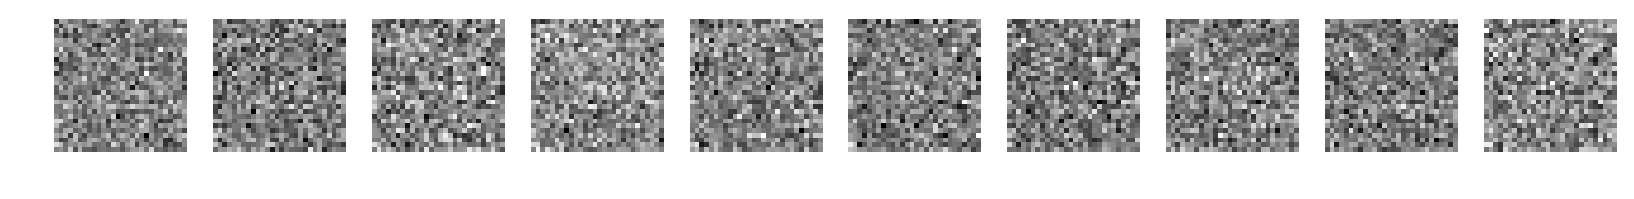

B. Results Through Half Epochs


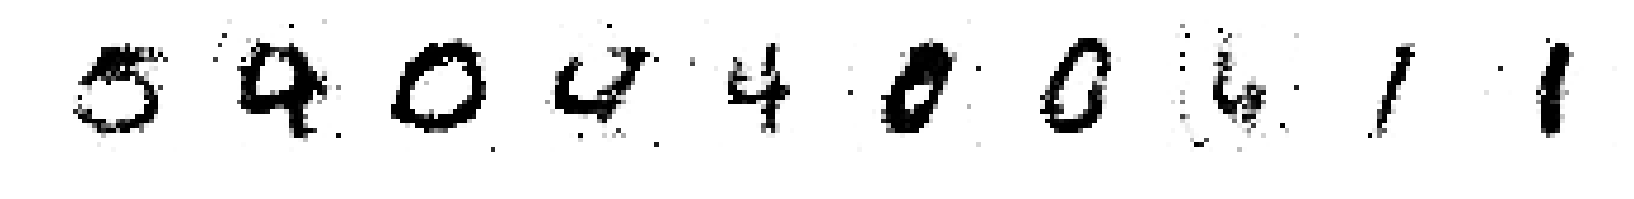

C. Results After All Epochs


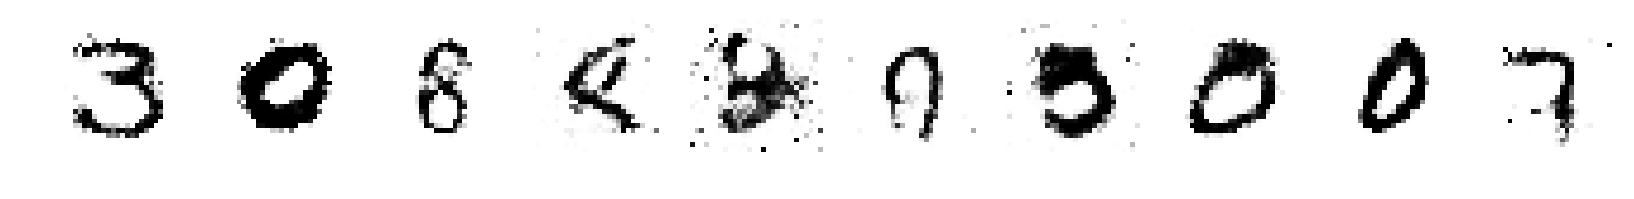

In [16]:
tracked_z = [Tensor(np.random.uniform(-1, 1, (1, opt.latent_dim))) for _ in range( 10 )]

G_loss, D_loss, inception, tracked = train(opt.n_epochs, tracked_z, verbose=False)

Before training, the generated images are pure noise, represented by the images in set `A`. Half way through training, and towards the end, the results begin to look synthetic. There is not much difference between `B` and `C` which indicates that the majority of learning occurs early. However, the numbers $8$ and $9$ in set `B` show to be dominate, this could be explained with having low entropy in the marginal distribution of samples, thereby indicating less variety in image labeles. This will be examined more in the plot of the Inception Score during training.

Visually most of the images in set `C` look good enough to classify, but there are still some inconsistencies. Most notably, the edges in the image are not very distinct and can even look blurry. Secondly, some of the images have speckles in the areas around surrounding the primary focus. This is a side effect of using a fully-connected network, where the entire sample is propagated through each layer. It is possible that specific weights in this model are updated to measure how to transform specific pixels, but noisy pixels do not have any negative influence on creating the subject of the image, the number. 

We can see how the networks learned over time with the following graphs.

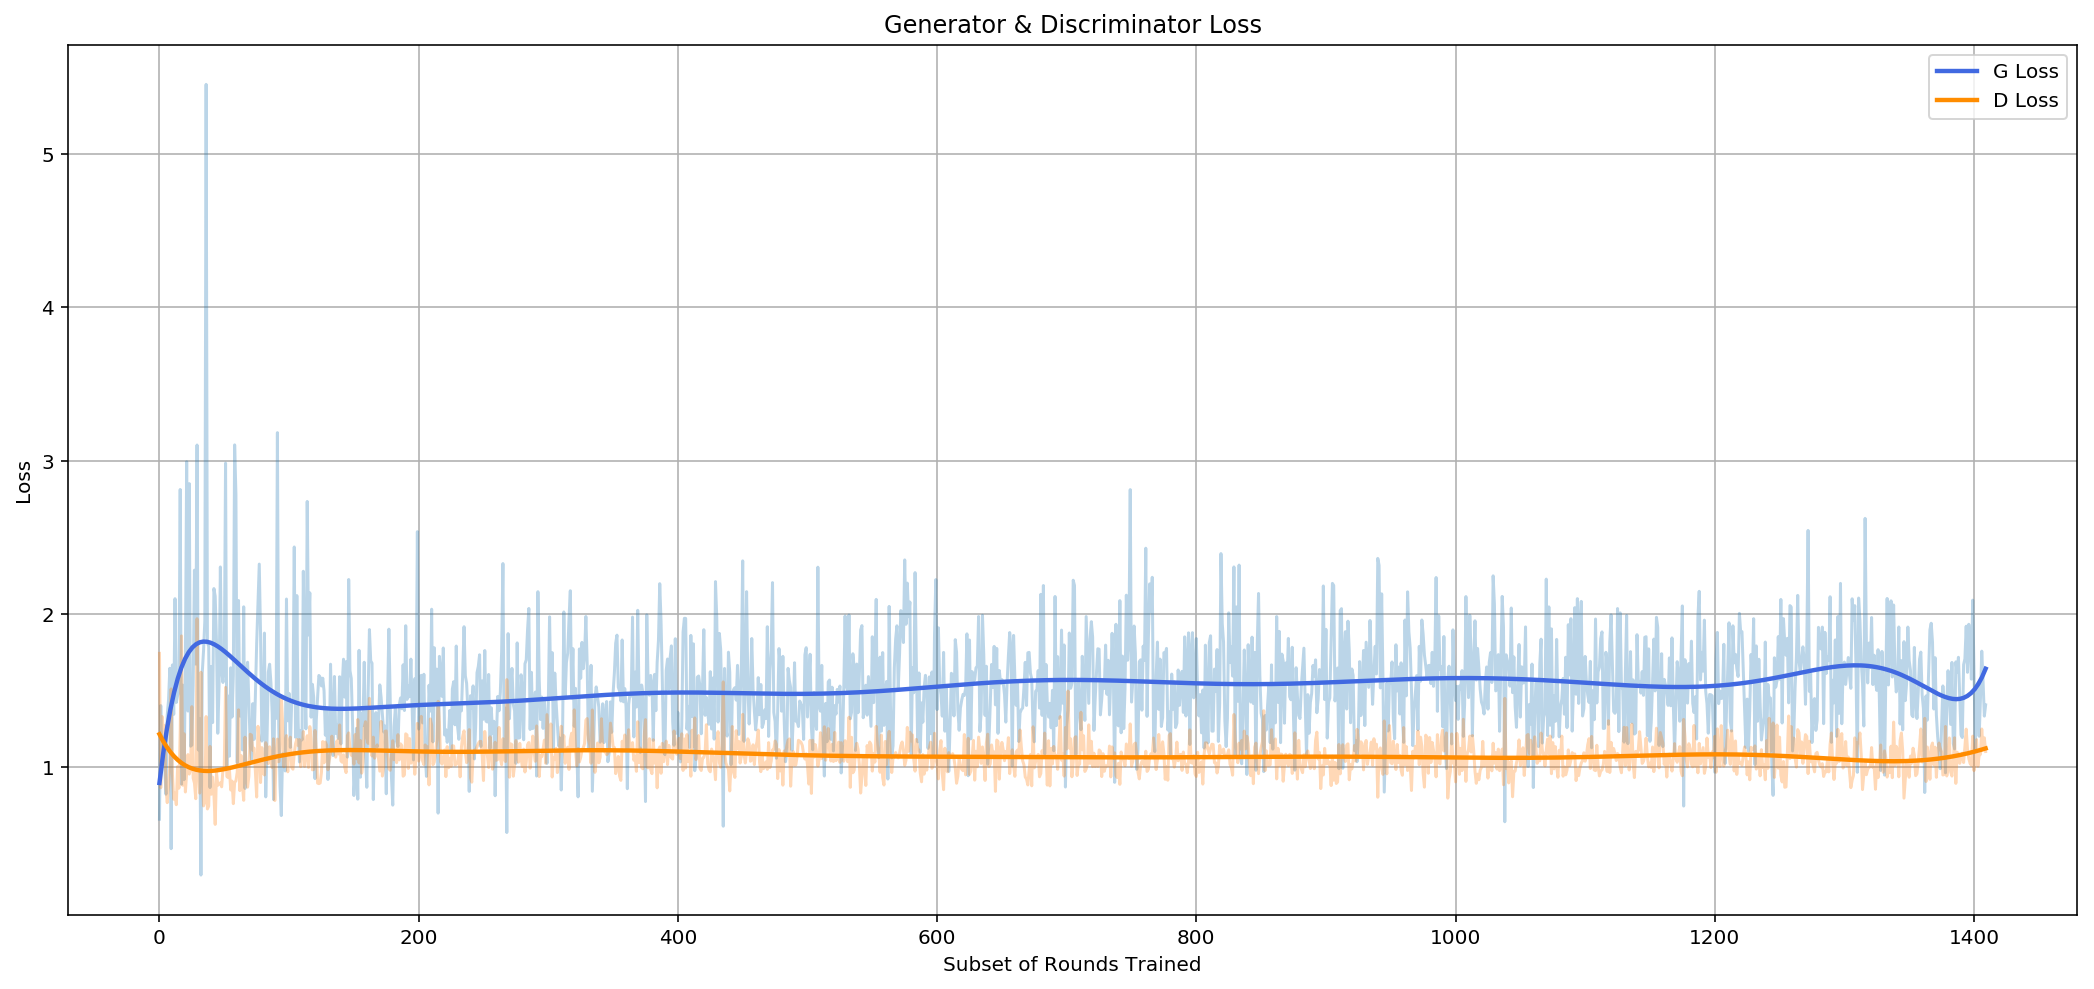

In [17]:
def plot_loss(G_loss, D_loss):
    plt.figure(figsize=(18, 8))

    plt.plot(G_loss, alpha=0.3)
    plt.plot(D_loss, alpha=0.3)
    
    x = np.arange(len(G_loss))
    p = np.poly1d(np.polyfit(x, G_loss, 15))
    xp = np.linspace(0, len(G_loss) - 1, 500)
    plt.plot(xp, p(xp), color='royalblue', ls='-',
             lw=2.2, label='G Loss')

    x = np.arange(len(D_loss))
    p = np.poly1d(np.polyfit(x, D_loss, 15))
    xp = np.linspace(0, len(D_loss) - 1, 500)
    plt.plot(xp, p(xp), color='darkorange', ls='-',
             lw=2.2, label='D Loss')

    plt.title('Generator & Discriminator Loss')
    plt.xlabel('Subset of Rounds Trained'); plt.ylabel('Loss')
    plt.grid(True); plt.legend();

plot_loss(G_loss, D_loss)

Above is a plot comparing the loss for **both** the generator and discriminator over time. The most interesting action occurs early in training within the first 100 sub-iterations. During this time, the generator is producing very noisy random images which are easily distinguishable from those that are real in the training dataset. The discriminator quickly learns, and evidently the loss starts to decline in the first few sub-iterations. At the same time, the loss for the generators starts to increase. The generator soon recovers, showing the adversarial corrections made in this algorithm to improve each networks.

Understanding the loss can be very difficult, it is typical for the loss to measure the accuracy of a prediction and how well a model *learns* over time. However, in the case seen above it is seen that the generators loss is increasing, but image quality is improving. This is strange. So, instead of using the loss to determine image quality, the metric is used as an evaluation of how well the models are compared to it's adversary.  

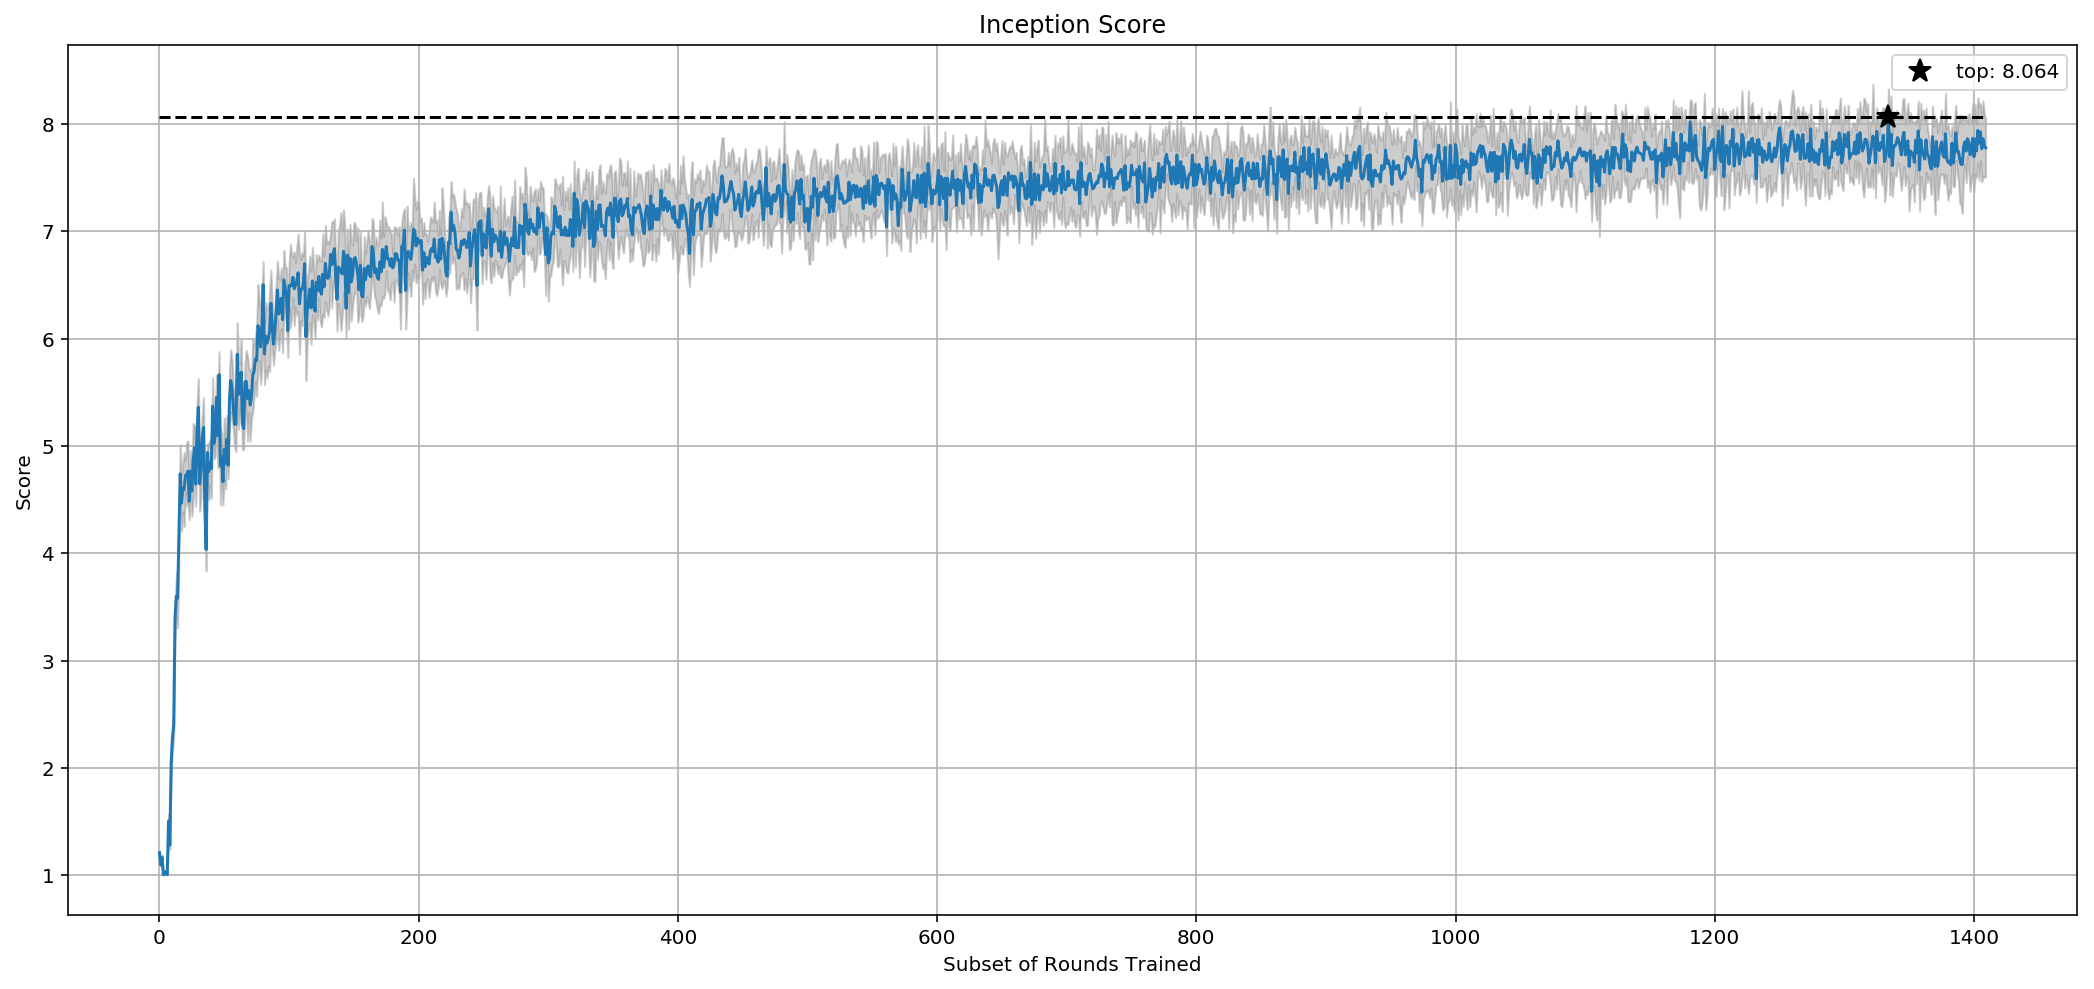

In [18]:
def plot_inception(inception):
    plt.figure(figsize=(18, 8))
    inception = np.array(inception)

    top_index = np.argmax(inception[:, 0])
    top = inception[top_index][0]

    plt.plot(inception[:, 0], '-')

    plt.fill_between(np.arange(0, inception.shape[0], 1),
                     inception[:, 0] - inception[:, 1],inception[:, 0] + inception[:, 1],
                     color='gray', alpha=0.4)

    plt.hlines(top, 0, inception.shape[0] - 1, linestyle='dashed')
    plt.plot(top_index, top, 'k*', markersize=12, label='top: {0:.3f}'.format(top))

    plt.xlabel('Subset of Rounds Trained'); plt.ylabel('Score')
    plt.grid(True); plt.title('Inception Score'); plt.legend(loc=0);
    
plot_inception(inception)

Over training, the Inception Score was calculated by computing the mean KL Divergence of 1000 samples from $G$. Initially this score is very low, indicating that the images are not easily classifiable. Meaning the conditional label distribution $p(y\:|\:\xv)$, and the marginal distribution $p(y)$ are very similar. Moreover, the two distributions are likely to have high entropy, containing unimportant feature but are randomly classified evenly amongst all classes.  

This can be visualized using the `plot_inception` function. The blue line represents the mean score, and the gray being the associated standard deviation. It can be seen that the score dramatically increases to roughly $5.0$ in the first 50 sub-iterations, then dips back down before increasing once again. This behavior is similar to what was seen in the first plot of the loss, and can be explained as $G$ starts to produce more realistic images containing classifiable features. From 100 sub-iterations forward, the score increases gradually until it hits a maximum of $7.851$. This value does not mean much outside the scope of this notebook because a custom network was trained for MNIST, but is helpful to see where learning plateaus and how one implementation compares to another - seen in the next [section](#Deep-Convolutional-GAN). 

To further visualize the evolution of training, an animation has been created using the `create_animation` function to see how tracked random variables are transformed during training. This function will return an animation that plays the results of each tracked random variable passing through $G$ over time.

In [19]:
def create_animation(tracked):
    fig = plt.figure(figsize=(18, 4));

    n_subplots = tracked.shape[1]
    axs = []
    for i in range(n_subplots):
        axs.append(fig.add_subplot(1, n_subplots, i + 1))
        
    ims = []
    for i, vector in enumerate(tracked):
        images = []
        for j, v in enumerate(vector):
            tmp = vectors_to_images(v).cpu().numpy()
            images.append(axs[j].imshow(-tmp.reshape((28, 28)), interpolation='nearest',
                                        cmap='gray', animated=True))
            axs[j].axis('off')
        ims.append(images)

    plt.close(fig);
    ani = animation.ArtistAnimation(fig, ims, interval=75, blit=True,
                                    repeat_delay=1500)
    return ani

create_animation(tracked)

As seen with the set `A` of images, the results are mostly noise in the first few sub-iterations. Following immediately thereafter, the images being to take shape of *multiple* numbers. The second image from the right is a good example of this - it begins to look like the number zero, then at half way it transforms in-between the numbers six and zero. Remember, all that is happening is a vector of $k$ uniform random variables are passed forward through a deep neural network, and in backpropogation the weights are updated to map the inverse transform function defined in the section on [random variables](#Random-Variables). The more the model learns, the more it generalizes across the samples in the label distribution. This explains why some of the tracked variables seem to warp between multiple images.

### Deep Convolutional GAN

While a vanilla neural network can get the job done to generate images, it often takes more trial and error to find the right parameters that result in *good* images. A major pitfall, even after finding parameters, is with the quality of images. Therefore, a different implementation of a Deep Convolutional GAN (DCGAN) is implemented following the same approach explained in this notebook is used. This is explored due to success Convolutional Neural Networks (CNNs) have with analyzing visual imagery. A paper by Radford *et al.* [ 13 ] explains an unsupervised approach using CNNs to implement a GAN where the use of convolutional and transposed convolutional layers are used for downsampling and upsampling.

First and foremost, the generator $G$ and discriminator $D$ have to be defined. These models implement the aforementioned paper, and is referenced from PyTorch's public code examples [ 18 ]. Modifications to the layers window and stride sizes were made to suit the data in this notebook.

In [20]:
class Generator(nn.Module):
    def __init__(self, opt):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(  opt.latent_dim, opt.img_size * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(opt.img_size * 4),
            nn.ReLU(True),
            # state size. (nimg_size * 4) x 4 x 4
            nn.ConvTranspose2d(opt.img_size * 4, opt.img_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.img_size * 2),
            nn.ReLU(True),
            # state size. (img_size * 2) x 8 x 8
            nn.ConvTranspose2d(opt.img_size * 2, opt.img_size    , 2, 2, 1, bias=False),
            nn.BatchNorm2d(opt.img_size),
            nn.ReLU(True),
            # state size. (img_size   ) x 14 x 14
            nn.ConvTranspose2d(opt.img_size    , opt.n_channels  , 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels) x 28 x 28
        )
        self.model.apply(self._init_weights)

    def _init_weights(self, m):
        classname = m.__class__.__name__
        if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
            m.weight.data.normal_(0.0, 0.02)
        elif type(m) == nn.BatchNorm2d:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0.00)

    def forward(self, input):
        return self.model(input)

class Discriminator(nn.Module):
    def __init__(self, opt):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (n_channels) x 28 x 28
            nn.Conv2d(opt.n_channels, opt.img_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_size    ) x 14 x 14
            nn.Conv2d(opt.img_size , opt.img_size * 2, 2, 2, 1, bias=False),
            nn.BatchNorm2d(opt.img_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_size * 2) x 8 x 8
            nn.Conv2d(opt.img_size * 2, opt.img_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.img_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_size * 4) x 4 x 4
            nn.Conv2d(opt.img_size * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.model.apply(self._init_weights)

    def _init_weights(self, m):
        classname = m.__class__.__name__
        if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
            m.weight.data.normal_(0.0, 0.02)
        elif type(m) == nn.BatchNorm2d:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0.00)
            
    def forward(self, input):
        return self.model(input)

The generator is constructed with four main layers, that is; one input layer, two hidden layers, and one output. Latent variables need to be upsampled to take the shape of a $n \times n$ image. Therefore, instead of increasing the number of units for each layer, as was done with the fully-connected network, the model will undergo a "deconvolutional" mechanism. This takes the a deep and narrow 4-dimensional vector $z$ with $k$ random variables. After each transposition, $z$ becomes wider and shallower starting with a depth of $112$. This continues until $z$ has a depth of $1$ (representing the number of color channels), and the shape of an image. The final layer outputs a value between $[-1,1]$ using the hyperbolic tangent ($\tanh$) function to get the values in-between the range of the normalized **real** images. 

In [21]:
G = Generator(opt)
G.to(device)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 112, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(56, 28, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(28, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

Contrary to $G$, the discriminator $D$ will use convolutional layers to downsample the $n \times n \times C : C = 1$ image to a single value that can be classified as **real** or **fake** using a logistic sigmoid function. The convolutional layers work by finding feature maps within the image by sliding a filter (with a shape denoted by the `kernel_size`) over the 3-dimensional input data. A product of the weights and input produces a result onto the next layers feature map. A stride is taken to determine how many pixels to move the filter for the next operation. In the end the convolutions result in different feature maps that *find* specific structures in the image, making it very effective in recognizing what is in an image.

In [22]:
D = Discriminator(opt)
D.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(28, 56, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(112, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

The same optimization and loss function will be used for training as the previous implementation.

In [23]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=opt.lr, betas=(opt.beta_1, opt.beta_2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=opt.lr, betas=(opt.beta_1, opt.beta_2))

loss = torch.nn.BCELoss()

In order to train our models appropriately, there will have to be simple modifications to the `train` function to account the shape differences of the inputs to each network. This was already implemented, and could be used by setting the `dc` (deep-convolutional) boolean parameter to `True`. Results will be shown intermittently, and metrics will be captured to be analyzed afterwards.

A. Initial Results


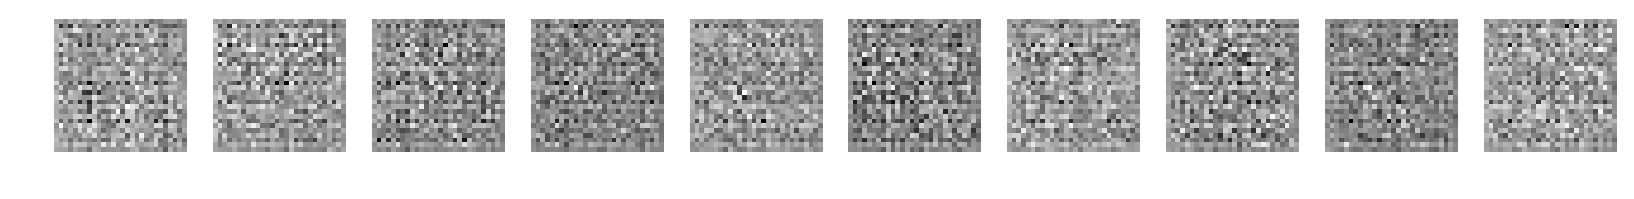

B. Results Through Half Epochs


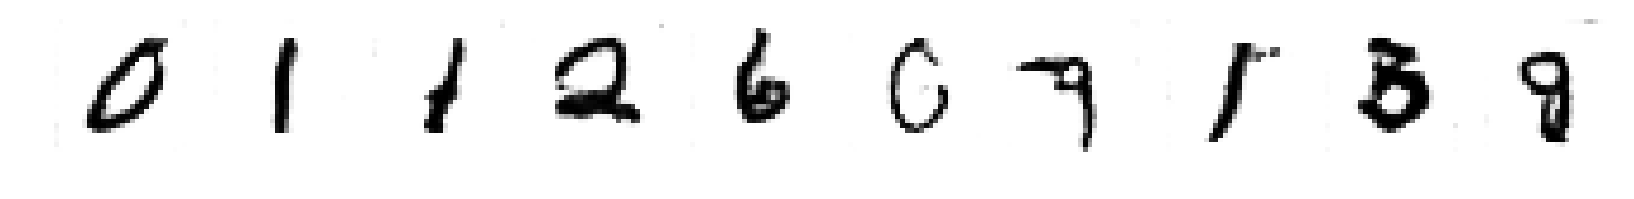

C. Results After All Epochs


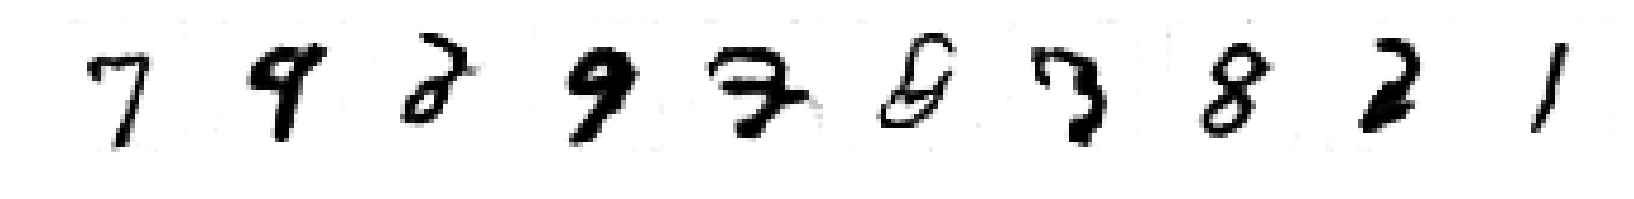

In [24]:
tracked_z = [Tensor(np.random.uniform(-1, 1, (1, opt.latent_dim, 1, 1))) for _ in range( 10 )]

G_loss, D_loss, inception, tracked = train(opt.n_epochs, tracked_z, dc=True, verbose=False)

Differences in the results from set `A` and `B` are astonishing. *Some* of the numbers are distinctly classifiable after just 15 epochs, and he learning after this point is negligible. The differences are even greater when compared to the fully-connected GAN implementation. Notably, the edges now have crisp and distinguishable properties, and there is little to no noise surrounding the subject of the image. This is likely due to the discriminator quickly learning what a **real** image is - enforcing strict properties defining the characteristics of different filters. Essentially, the discriminator is really good at catching **fake** images early. However, this is a benefit for the generator because it quickly learns what features minimize the probabilities for an image being labeled as fake - resulting in better images.

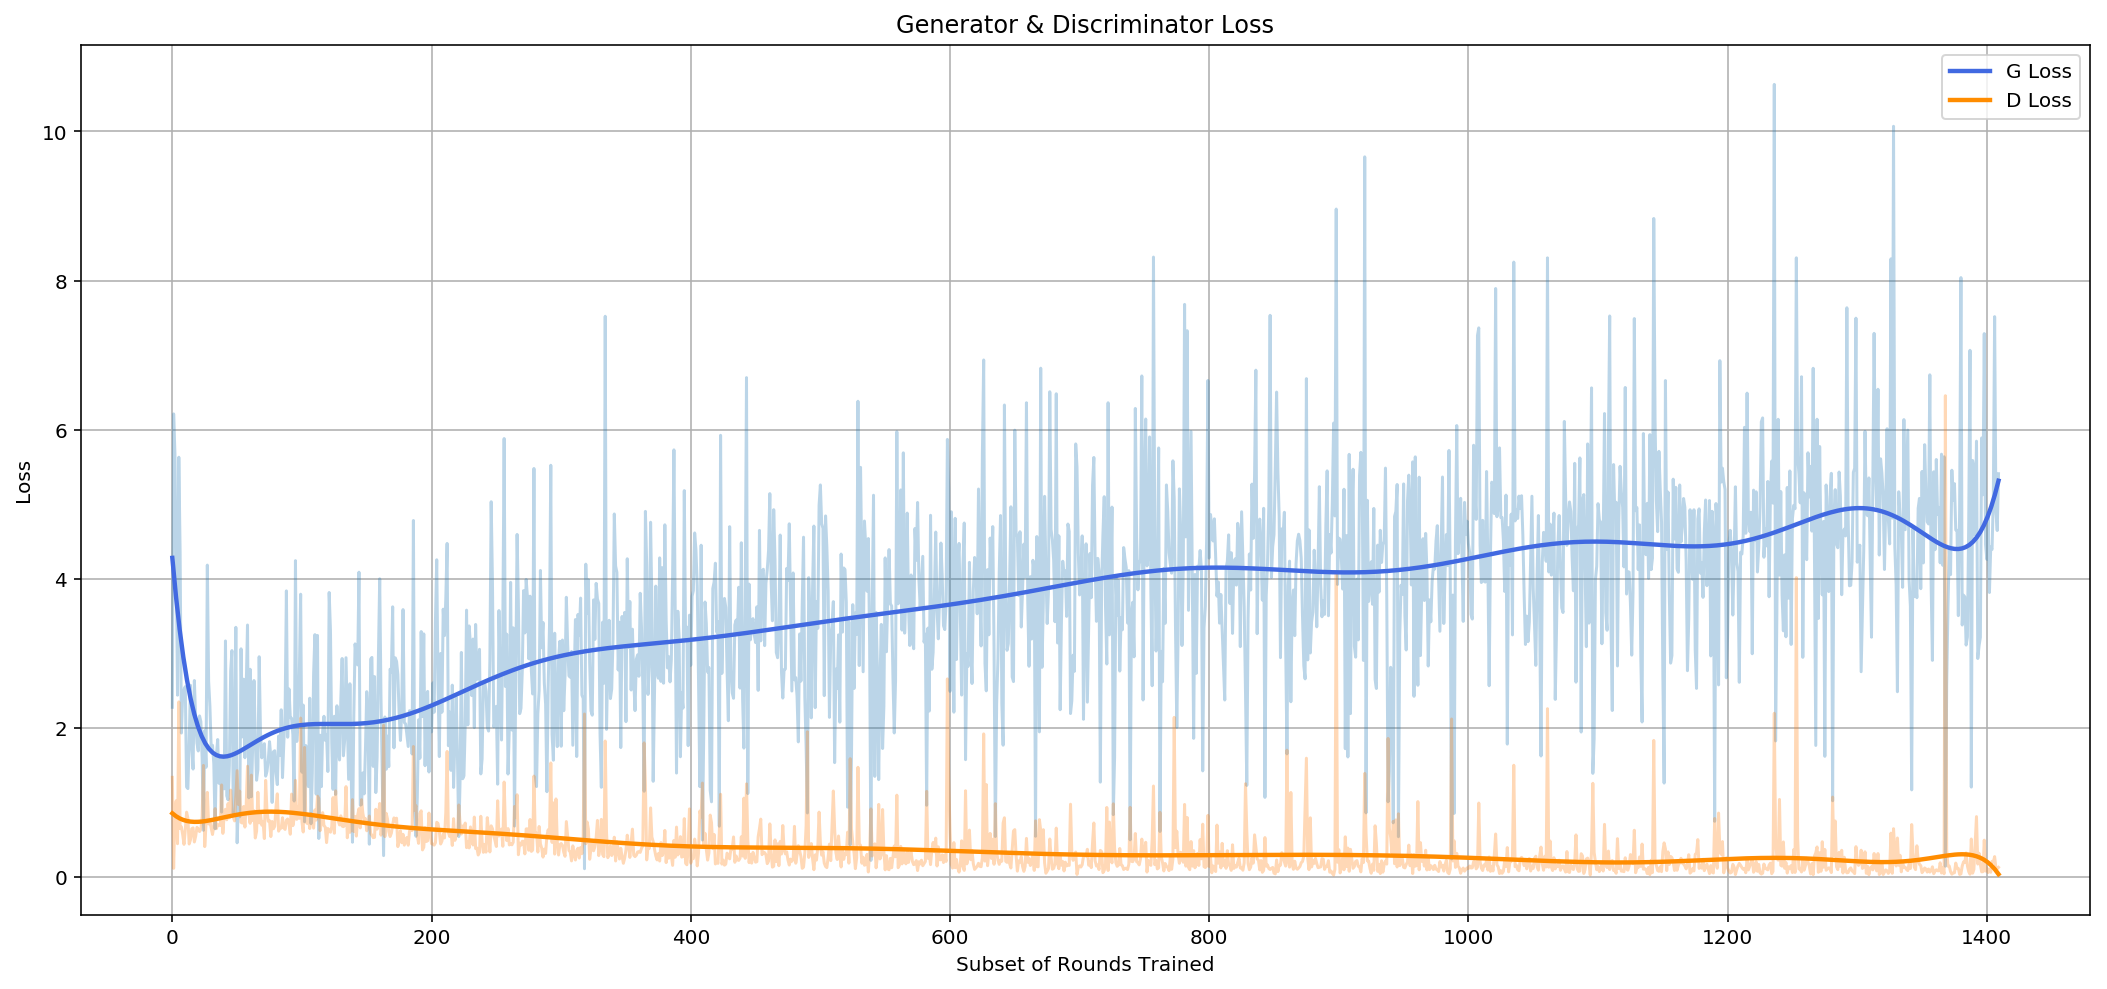

In [25]:
plot_loss(G_loss, D_loss)

We can examine the loss of the two networks during training to see if there are any trends that were not seen in the visual imagery. Similar to the fully-connected GAN, there is fluctuation in the loss within the first 100 sub-iterations, and then the values seem to be steadily changing. In fact, the same observation is seen with the generators loss increasing with the image quality - making it difficult to make much sense of how the networks learn.  

If we modify the loss values to visualize the likelihood of labeling the data, then perhaps it makes more sense - shown in the plot below. From the generators prospective, the probability of the discriminator labeling data as fake was minimized and can be shown with the blue line approaching zero over training. It might be expected that the discriminator would be closer to a value of one as it's adversary. However, there shows to be a gap in the probability for the discriminator correctly labeling data due to the loss being two part, that is; labeling data as real from the sample distribution is high, but the less so for labeling data as fake from the generator. 

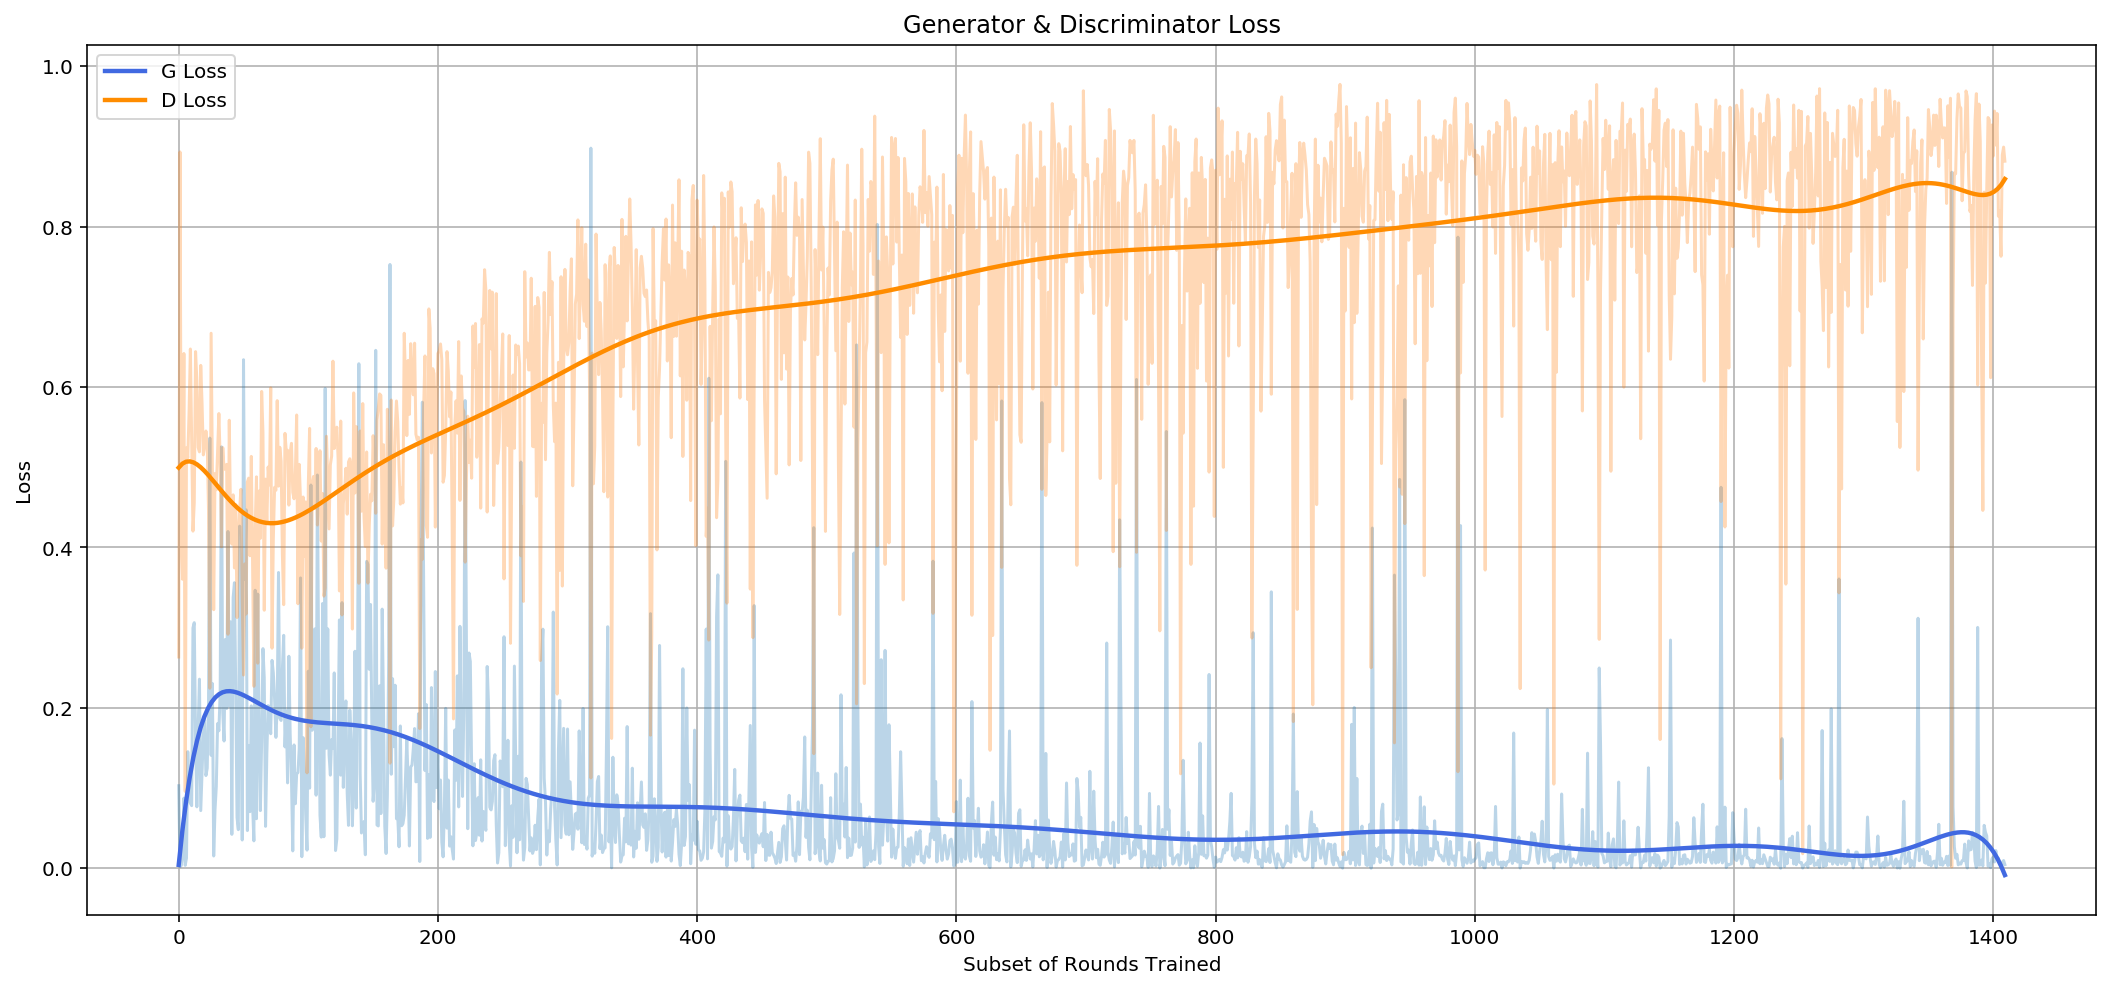

In [26]:
plot_loss(np.exp(-np.array(G_loss)), np.exp(-np.array(D_loss)))

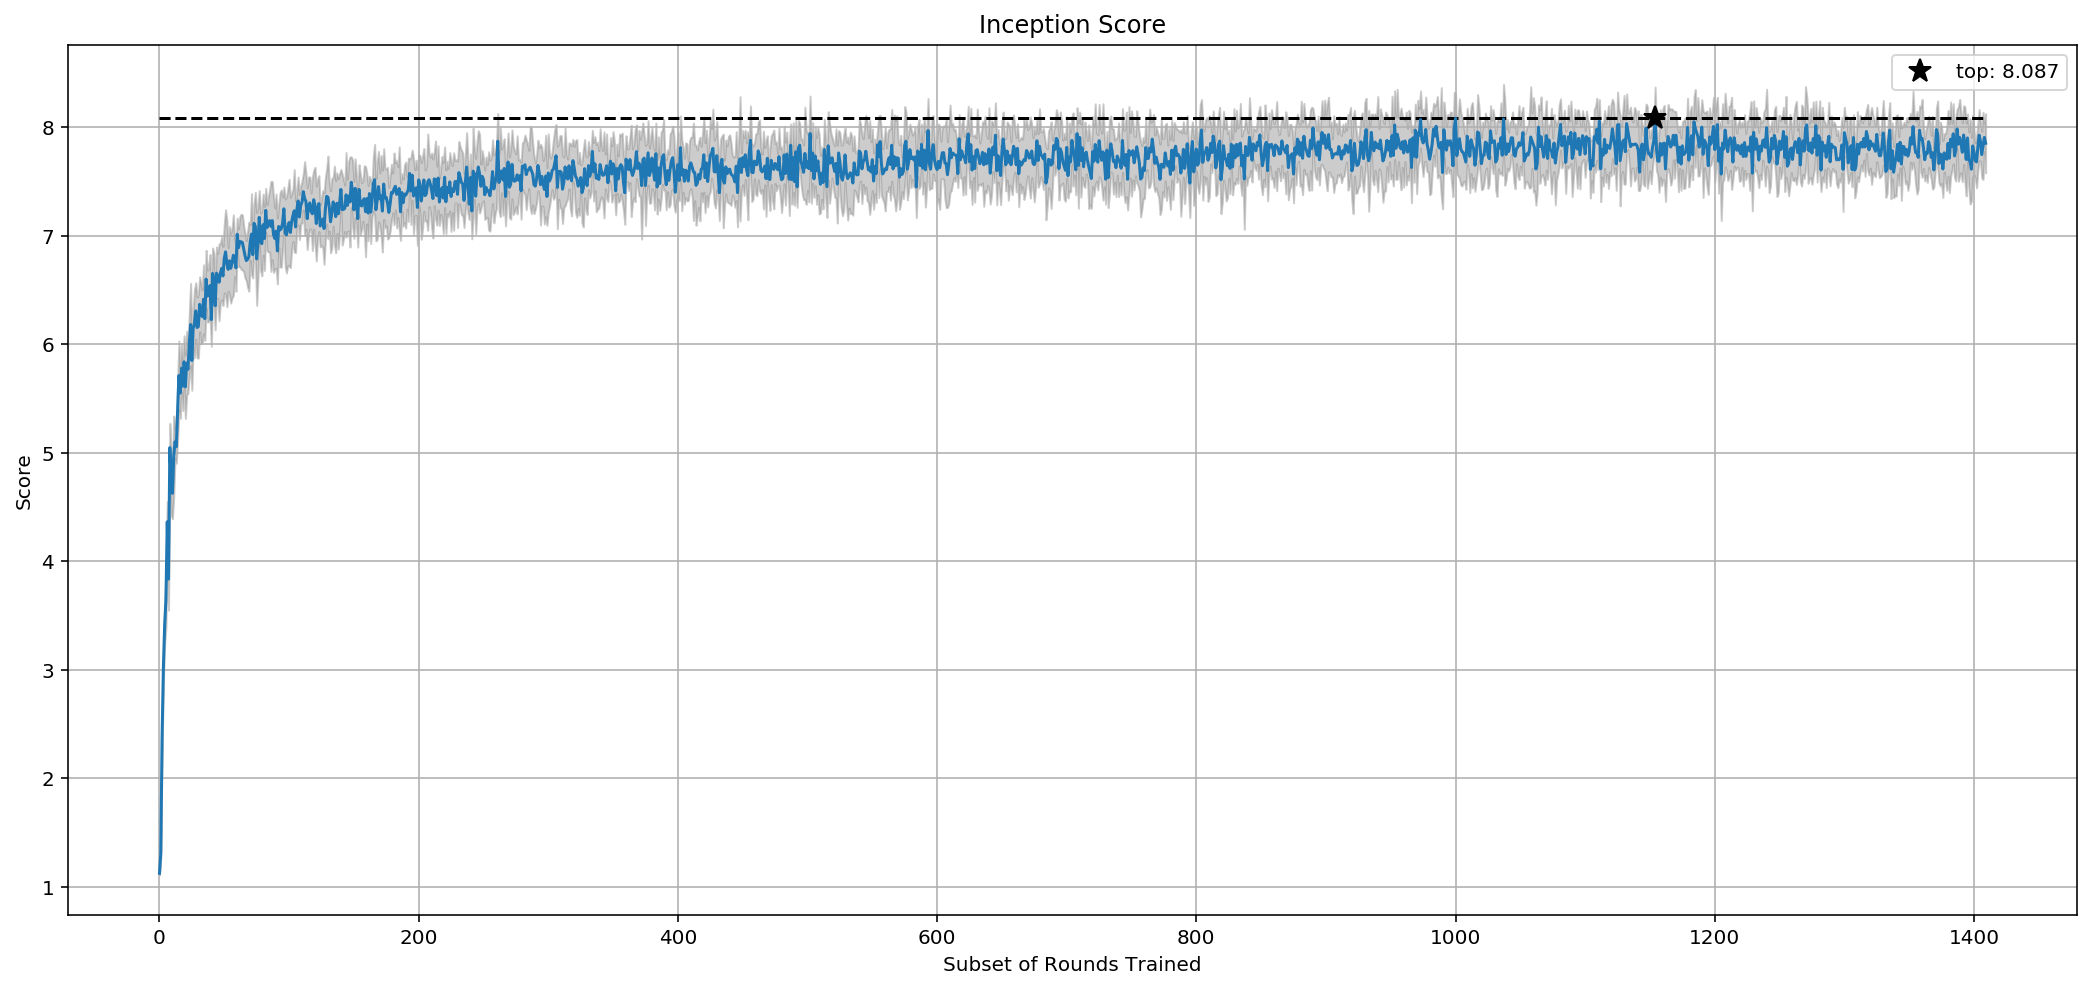

In [27]:
plot_inception(inception)

The plot of the Inception Score appears more well behaved as compared to the fully-connected graph. In the previous implementation it look nearly 300 sub-iterations to reach a score about $7.0$, but training with a DCGAN shows to reach the same score in the first 100 sub-iterations. This suggests that the model quickly learns to produce a variety of classifiable images.

In [28]:
create_animation(tracked)

The resulting animation compliments the plots and assumptions made previously, that is; values from the generator produce diverse and synthetic images early in training. The level Inception Score indicates that there is minimal improvements to the generator over time with each tracked image hardly changing. For the most part, each of the images is mapped to a number quickly and then has minor fluctuations in the features that make up that number - such as the number six in the second image from the right.

# Future Work  

It is remarkable how well these models behave and produce images that are indistinguishable from the true sample space. It seems as if the random variables have less influence on the outcome, and the underlying weights of the generator are what truly map the complex distribution of the output - this was the presumption that was made in the section on [random variables](#Random-Variables). However, through numerous experiments it was seen that sampling from a continuous uniform distribution over the interval $[-1, 1]$ preformed preformed better than sampling over the interval $[0, 1]$. This could be due to having a larger range of values, introducing a negative, the underlying properties of a uniform distribution, or related to the MNIST data itself. Perhaps drawing from a normal or exponential distribution and testing with a different set of data would lead to better results.

Implementing a way to measure the accuracy of the sampled images have proven to be a difficult task. Applying the Inception Score (IS) on models other than the ImageNet dataset provides little insight to comparing generative models (outside this notebook) [ 19 ]. In fact, the IS has shown various suboptimalities that can be deceiving and add to the difficulty for evaluating generative models [ 8 ]. In an attempt to resolve some of the issues, there has been energy devoted to finding new methods, including the creation of the Fréchet Inception Distance (FID) metric introduced by Heusel *et al.* [ 20 ]. The authors show more stable results and improvements over the IS, but it is still not perfect and it is encouraged to continue research on the topic.  

Evaluative approaches to generative networks could evolve through the use of ensembles of convolutional neural networks - which has shown significant improvements to the empirical and theoretical accuracy of models [ 21 ]. Perhaps this idea could be leveraged to get consensus on what generative model are producing in an attempt to measure how recognizable the results are. However, there is no formal approach to this, and it is likely this method will have to incorporate other characteristics from the IS, FID or other machine learning algorithms to be successful.

# Conclusion  

This notebook explored the structure and training process of a fully-connected GAN and DCGAN for generating new images of numbers similar to the MNIST dataset. It is evident that the DCGAN architecture is a more superior model, and produces more accurate and sharper images. Even though this notebook only explored MNIST, it is expected this results holds true with different data. This could be validated by modeling different subjects such as cars, bridges, animals, etc. from datasets similar to CIFAR-10 and CIFAR-100. All this would entail is minor modifications to the models parameters and structure to represent the data and map the generator to the target sample space.

Creating new images is a creative application of GANs, but it is not the only. The models in this notebook could even be extended to replicate other text-to-image or image inpainting applications. However, the purpose was to gather a deeper understanding behind these models to open the door for different demands. This could include experimenting across multiple disciplines, or perhaps advancing the research of computer vision through video generation and future predictions, generative 3-dimensional modeling and editing, and other areas of interest.  

## References

[ 1 ] Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville: "Generative Adversarial Networks", 2014; <a href='http://arxiv.org/abs/1406.2661' style="color:black;">arXiv:1406.2661</a>.

[ 2 ] "Uniform Distribution", 2019; <a href="https://en.wikipedia.org/wiki/Uniform_distribution" style="color:black;">wiki:Uniform_distribution</a>

[ 3 ] Stefan Scholtes: "The Inverse Transform Method", 2001; <a href="http://www3.eng.cam.ac.uk/~ss248/G12-M01/Week1/ITM.pdf" style="color:black;">PDF</a>

[ 4 ] "Generative Model", 2019; <a href="https://en.wikipedia.org/wiki/Generative_model" style="color:black;">wiki:Generative_model</a>

[ 5 ] Michael Chiu, Jonathan Lorraine, Ali Punjani, Michael Tao: "GAN Foundations", 2016; <a href="https://www.cs.toronto.edu/~duvenaud/courses/csc2541/slides/gan-foundations.pdf" style="color:black;">PDF</a>

[ 6 ] Tim Salimans, Ian Goodfellow, Wojciech Zaremba, Vicki Cheung, Alec Radford: "Improved Techniques for Training GANs", 2016; <a href='http://arxiv.org/abs/1606.03498' style="color:black;">arXiv:1606.03498</a>.

[ 7 ] "Kullback–Leibler Divergence", 2019; <a href="https://en.wikipedia.org/wiki/Kullback–Leibler_divergence" style="color:black;">wiki:Kullback–Leibler_divergence</a>

[ 8 ] Shane Barratt: "A Note on the Inception Score", 2018; <a href='http://arxiv.org/abs/1801.01973' style="color:black;">arXiv:1801.01973</a>.

[ 9 ] "Softmax Function", 2019 <a href="https://en.wikipedia.org/wiki/Softmax_function" style="color:black;">wiki:Softmax_function</a>

[ 10 ] Catherine Olsson, Tim Salimans, Wojciech Zaremba: "Inception Score Implementation", 2018; <a href="https://github.com/openai/improved-gan/blob/master/inception_score/model.py" style="color:black;">GitHub:openai/improved-gan/inception_score/model.py</a>

[ 11 ] Augustus Odena, Christopher Olah: "Conditional Image Synthesis With Auxiliary Classifier GANs", 2016; <a href='http://arxiv.org/abs/1610.09585' style="color:black;">arXiv:1610.09585</a>.

[ 12 ] Xudong Mao, Qing Li, Haoran Xie, Raymond Y. K. Lau, Zhen Wang: "Least Squares Generative Adversarial Networks", 2016; <a href='http://arxiv.org/abs/1611.04076' style="color:black;">arXiv:1611.04076</a>.

[ 13 ] Alec Radford, Luke Metz: "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks", 2015; <a href='http://arxiv.org/abs/1511.06434' style="color:black;">arXiv:1511.06434</a>.

[ 14 ] Martin Arjovsky, Soumith Chintala: "Wasserstein GAN", 2017; <a href='http://arxiv.org/abs/1701.07875' style="color:black;">arXiv:1701.07875</a>.

[ 15 ] "PyTorch Master Documentation", 2019; <a href="https://pytorch.org/docs/stable/nn.html#bceloss" style="color:black;">PyTorch</a>

[ 16 ] Jonathan Kao, "Generative Adversarial Networks", 2018; <a href="https://seas.ucla.edu/~kao/nndl/lectures/gans.pdf" style="color:black;">PDF</a>

[ 17 ] Diederik P. Kingma: "Adam: A Method for Stochastic Optimization", 2014; <a href='http://arxiv.org/abs/1412.6980' style="color:black;">arXiv:1412.6980</a>.

[ 18 ] "Deep Convolution Generative Adversarial Networks", 2018; <a href="https://github.com/pytorch/examples/tree/master/dcgan" style="color:black;">GitHub:pytorch/examples//dcgan</a> 

[ 19 ] Mihaela Rosca, Balaji Lakshminarayanan, David Warde-Farley: "Variational Approaches for Auto-Encoding Generative Adversarial Networks", 2017; <a href='http://arxiv.org/abs/1706.04987' style="color:black;">arXiv:1706.04987</a>. 

[ 20 ] Martin Heusel, Hubert Ramsauer, Thomas Unterthiner, Bernhard Nessler: "GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium", 2017; <a href='http://arxiv.org/abs/1706.08500' style="color:black;">arXiv:1706.08500</a>. 

[ 21 ] Cheng Ju, Aurélien Bibaut: "The Relative Performance of Ensemble Methods with Deep Convolutional Neural Networks for Image Classification", 2017; <a href='http://arxiv.org/abs/1704.01664' style="color:black;">arXiv:1704.01664</a>.

In [4]:
import io
from nbformat import current
import glob

nbfile = glob.glob('gan-project.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
    
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
    
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
        
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file gan-project.ipynb is 6438


--  
Jason D. Stock